<a href="https://colab.research.google.com/github/enzoconejero/utnba-iaa-2021-property-price-prediction/blob/master/propierati_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicción de precios de Propierati con regresión



# Importar librerías

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import ipywidgets as widgets

# Cargar dataset
Por el momento usamos drive para no equivocarnos con azure y tener que pagar

---



In [ ]:
# Montar volumen de drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# Importar dataset
# https://ia1avanzada.blob.core.windows.net/data-properati/ar_properties.csv 
# path = "/content/gdrive/MyDrive/ar_properties.csv"
raw_data = pd.read_csv("https://ia1avanzada.blob.core.windows.net/data-properati/ar_properties.csv", delimiter=',', parse_dates = True)
print('Dataset cargado')

Dataset cargado


# Preparar datos

## Reiniciar Datase de caba

In [ ]:
data = raw_data.copy()
data = data[data.l2 == 'Capital Federal']
data = data.loc[data['property_type'].isin(['Departamento', 'PH', 'Casa', 'Oficina'])]

print(f'Total: {len(data)}')
print(f'Alquiler {len(data[data.operation_type == "Alquiler"])}')
print(f'Alquiler temproal {len(data[data.operation_type == "Alquiler temporal"])}')
print(f'Venta {len(data[data.operation_type == "Venta"])}')

Total: 185305
Alquiler 45797
Alquiler temproal 12230
Venta 127278


In [ ]:
data = data[data.operation_type == 'Venta']
data = data[data.currency == 'USD']
print(f'{len(data)} propiedades para compra-venta en CABA')
data.isnull().sum()

123946 propiedades para compra-venta en CABA


id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                  9047
lon                  9088
l1                      0
l2                      0
l3                   1794
l4                 118407
l5                 123946
l6                 123946
rooms                8973
bedrooms            26241
bathrooms            6862
surface_total       31982
surface_covered     30553
price                   0
currency                0
price_period        74114
title                   0
description             0
property_type           0
operation_type          0
dtype: int64

## Completar el barrio
Se completa con el último valor de l3 o l4

In [ ]:
data['l4'] = data.l4.fillna(0)
data['l4'] = np.where(data['l4'] == 0, data['l3'], data['l4'])
data.rename(columns={'l4': 'neighborhood'}, inplace=True)
data.head()

id    ad_type  ... property_type operation_type
215  vkz8FlyDlfb1zV2igMKWAQ==  Propiedad  ...  Departamento          Venta
216  PjbG6SXWEFqygd0c+8txUQ==  Propiedad  ...  Departamento          Venta
224  8LiIhybSnKcX8sHgPDVqAg==  Propiedad  ...  Departamento          Venta
225  IjL9wAZSeYB+y7Y8Uzzczw==  Propiedad  ...       Oficina          Venta
226  jGYSk7ecbQzoa2OIfwkJcQ==  Propiedad  ...  Departamento          Venta

[5 rows x 25 columns]

## Filtrar datos completos

In [ ]:
data = data.drop(columns=['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3', 'l5', 'l6', 'id', 'title', 'description', 'price_period', 'currency', 'operation_type'], axis=1)
data.head()

,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
215,Villa Luro,3.0,NaN,2.0,84.0,74.0,135900.0,Departamento
216,Boca,1.0,NaN,1.0,28.0,26.0,56000.0,Departamento
224,Barracas,2.0,NaN,2.0,82.0,71.0,270000.0,Departamento
225,Belgrano,NaN,NaN,NaN,23.0,23.0,72000.0,Oficina
226,Paternal,1.0,NaN,1.0,25.0,23.0,50400.0,Departamento


In [ ]:
data_completa = data.dropna()
print(f'Propiedades con datos completos: {len(data_completa)}')
data_completa.head()

Propiedades con datos completos: 67502


,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
235,Mataderos,2.0,1.0,1.0,61.0,61.0,110600.0,Departamento
236,Almagro,2.0,1.0,1.0,143.0,143.0,239000.0,Departamento
237,Palermo,2.0,1.0,1.0,40.0,34.0,89000.0,Departamento
238,Paternal,2.0,1.0,1.0,59.0,36.0,82000.0,PH
240,Saavedra,2.0,1.0,1.0,46.0,43.0,110000.0,Departamento


## Revisar extremos

In [ ]:
def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

In [ ]:
data_filt = data_completa.copy()
print(data_filt.describe().transpose())

data_filt.head()
# data_filt[data_filt.bedrooms > 20].head()

# quantil_sup = data_filt['surface_covered'].quantile(0.975)
# data_filt[data_filt.surface_covered >= quantil_sup].head()

# # quantilizables = ['rooms', 'bedrooms', 'surface_total', 'surface_covered', 'price_usd']
quantilizables = ['rooms', 'bedrooms', 'surface_total', 'surface_covered', 'price']

for column in quantilizables:
    extremo = data_filt[column].quantile(0.975)
    print(f'{column} - {extremo}')
    data_filt = data_filt[data_filt[column] <= extremo]
    print("\n\n\n",data_filt.describe().transpose())
    
# # Cuantil minimo para precio
minimo = data_filt['price'].quantile(0.001)
print(minimo)
data_filt = data_filt[data_filt['price'] >= minimo]

generar_estadisticas_detalladas(data_filt, '> Estadísticas de los datos')
# # data_filt.head()
# # data_filt.rooms = data_filt.rooms.quantile(0.975)
# # print(data_filt.describe().transpose())
# # data_pca.pca1.quantile(0.975)

# # data_filt.rooms.min()


                   count           mean  ...       75%        max
rooms            67502.0       2.998222  ...       4.0       30.0
bedrooms         67502.0       2.010459  ...       3.0       22.0
bathrooms        67502.0       1.558250  ...       2.0       15.0
surface_total    67502.0     119.736215  ...     112.0   140380.0
surface_covered  67502.0     102.823739  ...      97.0   170000.0
price            67502.0  275270.438639  ...  282000.0  8500000.0

[6 rows x 8 columns]
rooms - 6.0



                    count           mean  ...       75%        max
rooms            66387.0       2.911850  ...       4.0        6.0
bedrooms         66387.0       1.955473  ...       3.0       16.0
bathrooms        66387.0       1.526941  ...       2.0       10.0
surface_total    66387.0     115.412912  ...     110.0   140380.0
surface_covered  66387.0      99.419992  ...      94.0   170000.0
price            66387.0  264245.371353  ...  278000.0  8500000.0

[6 rows x 8 columns]
bedrooms - 4.0



,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
neighborhood,object,{ Palermo 7413 ; Belgrano 5385 ; Almagro 4306 ; Villa Crespo 4227 ; Caballito 4209 ; ... ; Parque Chas 94 ; Villa Real 66 ; Villa Soldati 34 ; Catalinas 8 ; Villa Riachuelo 8 },-,0,0
rooms,float64,[ 1.00 ; 6.00 ],2.779 ± 1.024,0,0
bedrooms,float64,[ -1.00 ; 4.00 ],1.840 ± 0.856,0,0
bathrooms,float64,[ 1.00 ; 10.00 ],1.402 ± 0.645,0,0
surface_total,float64,[ 10.00 ; 291.00 ],78.209 ± 41.429,0,0
surface_covered,float64,[ 1.00 ; 200.00 ],68.351 ± 33.644,0,0
price,float64,[ 34300.00 ; 700000.00 ],199082.937 ± 121280.621,0,0
property_type,object,{ Departamento 53810 ; PH 6089 ; Casa 837 ; Oficina 308 },-,0,0


Tiene 8 atributos y 61044 ejemplos.




## Box de valores

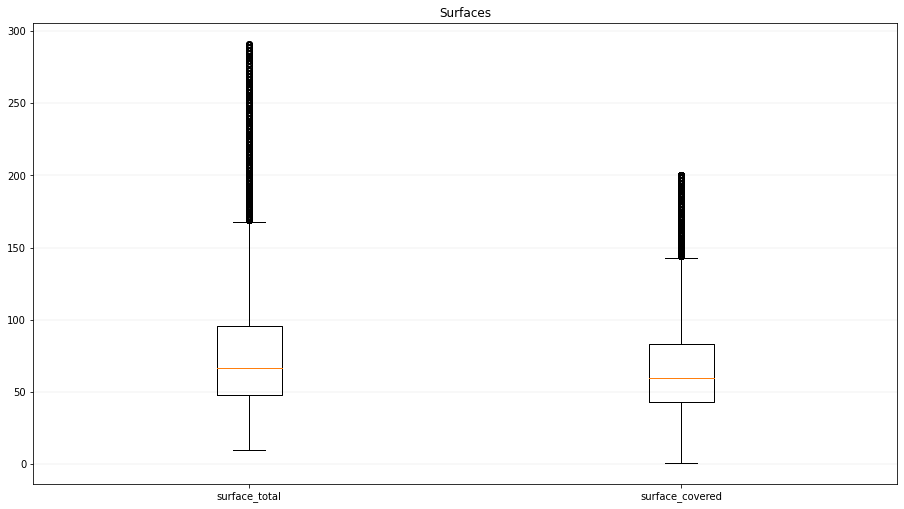

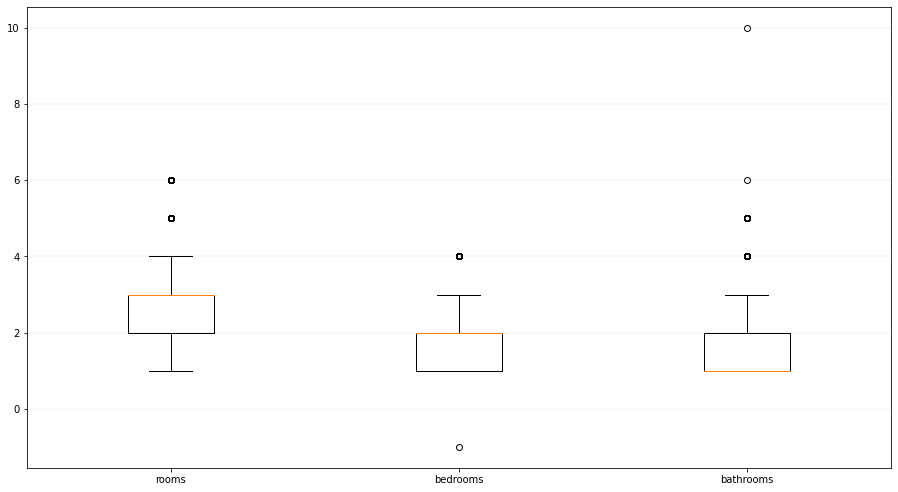

In [ ]:
data_stat = data_filt.copy()

def genGraph_BoxPlot(ndf, titulo):
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  colValues = []
  for col in ndf.columns:    
    if ndf[col].dtypes != "object":
      legValues.append( col )
      colValues.append( ndf[col].fillna(0.001) )
  if len(colValues)>0:
    ax = fig.add_axes( [0, 0, 0.8, 0.8] )
    ax.boxplot( colValues )
    ax.set_xticklabels( legValues )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.show()

x = data_stat.copy().drop(['price', 'rooms', 'bedrooms', 'bathrooms'], axis=1)
genGraph_BoxPlot(x, 'Surfaces')

x = data_stat.copy().drop(['price', 'surface_total', 'surface_covered'], axis=1)
genGraph_BoxPlot(x, '')

## Estandarizar valores

In [ ]:
# auxiliar
def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

#def encode(df: pd.DataFrame):
#    encoder = LabelEncoder()
#    return encoder.fit_transform(df)

#encodables = ['neighborhood', 'property_type', 'operation_type']

#for encodable in encodables:
#   data_completa[encodable] = encode(data_completa[encodable])

#data_completa.head()
#@title Normalizar datos numéricos (OPCIONAL) { run: "auto" }

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

data_norm = data_filt.copy()

if aplica_normalizacion:

    print("5 primeros ejemplos antes de normalizar: ")
    display(data_norm.head())

    # elegir el método de normalización
    scaler = {
        'Standard Scaler': StandardScaler(),
        'MinMax Scaler': MinMaxScaler(),
        'MaxMax Scaler': MaxAbsScaler(),
        'Robust Scaler': RobustScaler()
    }[tipo_normalizacion]

    # aplica la normalización sólo en columnas de datos
    for columna in data_norm.columns:
        if data_norm[columna].dtypes != "object": 
            data_norm[columna] = scaler.fit_transform(data_norm[columna].values.reshape(-1, 1))

    print("\n\n5 primeros ejemplos después de normalizar: ")
    display( data_norm.head() )

    # muestra las estadísticas del normalizado
    generar_estadisticas_detalladas(data_norm, "> Estadísticas de los datos normalizados") 
else:
  print("No se aplica la normalización de los datos.")

5 primeros ejemplos antes de normalizar: 


,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
235,Mataderos,2.0,1.0,1.0,61.0,61.0,110600.0,Departamento
236,Almagro,2.0,1.0,1.0,143.0,143.0,239000.0,Departamento
237,Palermo,2.0,1.0,1.0,40.0,34.0,89000.0,Departamento
238,Paternal,2.0,1.0,1.0,59.0,36.0,82000.0,PH
240,Saavedra,2.0,1.0,1.0,46.0,43.0,110000.0,Departamento




5 primeros ejemplos después de normalizar: 


,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
235,Mataderos,-0.760747,-0.980746,-0.623106,-0.415386,-0.218493,-0.729578,Departamento
236,Almagro,-0.760747,-0.980746,-0.623106,1.563930,2.218777,0.329132,Departamento
237,Palermo,-0.760747,-0.980746,-0.623106,-0.922284,-1.021008,-0.907679,Departamento
238,Paternal,-0.760747,-0.980746,-0.623106,-0.463662,-0.961563,-0.965397,PH
240,Saavedra,-0.760747,-0.980746,-0.623106,-0.777456,-0.753503,-0.734525,Departamento



 > Estadísticas de los datos normalizados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
neighborhood,object,{ Palermo 7413 ; Belgrano 5385 ; Almagro 4306 ; Villa Crespo 4227 ; Caballito 4209 ; ... ; Parque Chas 94 ; Villa Real 66 ; Villa Soldati 34 ; Catalinas 8 ; Villa Riachuelo 8 },-,0,0
rooms,float64,[ -1.74 ; 3.15 ],-0.000 ± 1.000,0,0
bedrooms,float64,[ -3.32 ; 2.52 ],-0.000 ± 1.000,0,0
bathrooms,float64,[ -0.62 ; 13.34 ],-0.000 ± 1.000,0,0
surface_total,float64,[ -1.65 ; 5.14 ],-0.000 ± 1.000,0,0
surface_covered,float64,[ -2.00 ; 3.91 ],0.000 ± 1.000,0,0
price,float64,[ -1.36 ; 4.13 ],0.000 ± 1.000,0,0
property_type,object,{ Departamento 53810 ; PH 6089 ; Casa 837 ; Oficina 308 },-,0,0


Tiene 8 atributos y 61044 ejemplos.




# Gráficos estadísticos

> Esto lo estamos viendo, todavía no lo acomodamos bien

In [ ]:
# Existen data_filt y data_norm
data_stat = data_filt.copy()

In [ ]:
#@title Aplicar Clustering ( K-Means ) { run: "auto" }
# función auxiliar para separar datos de entrada y de salida
def separarDatosXY(ndf, atributo_clase="", xSoloNros=True):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # saca el atributo clase (OPCIONAL)
  if atributo_clase == "":
    Y = []
  else:
    # datos atributo clase
    Y = np.array( cdf.pop(atributo_clase).fillna("-NAN-") )
  if xSoloNros:
    # se queda sólo con los atributos numéricos (OPCIONAL)
    for col in cdf.columns:
      if cdf[col].dtypes == "object":
          cdf.pop( col )
  # datos de entrada
  X = np.array(cdf.fillna(0.001))
  return X, Y, np.array(cdf.columns)

#@markdown Cantidad de clústeres a generar:
cantidad_clusters =  3#@param {type:"integer"}
#@markdown Nombre del atributo clase / objetivo a descartar en el clustering:
atributo_clase_descartar_clustering = "" #@param {type:"string"}
ndf = data_norm
# como mínimo se tienen que generar dos clusters
if cantidad_clusters < 2:
  cantidad_clusters = 2

# controla que exista el atributo_clase
if atributo_clase_descartar_clustering != "" and atributo_clase_descartar_clustering not in ndf:
  raise ValueError("El atributo '" + atributo_clase_descartar_clustering + "' no existe en los datos cargados!!!")

# obtiene los datos para entrenar el algoritmo
X, Y, colValues = separarDatosXY(ndf, atributo_clase_descartar_clustering, xSoloNros=True)
colValues = list(colValues)

# Entrena K-Means
kmeans = KMeans(n_clusters=cantidad_clusters).fit(X)
centroids = kmeans.cluster_centers_
print("Centroides Generados: \n", centroids)
print("\n")

# Determina la salida
labels = kmeans.predict(X)

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY])

def cambiaSeleccion(x, y):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  plt.figure(figsize=(15,8))
  plt.scatter(X[:, colValues.index(x)], X[:, colValues.index(y)], c=labels)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY})
display(ui, out)

Centroides Generados: 
 [[-0.95943925 -0.97021774 -0.54750282 -0.7341937  -0.77283648 -0.60453522]
 [ 0.40134499  0.39221688 -0.07842606  0.04473526  0.04832661 -0.03731673]
 [ 1.30985027  1.35556233  1.44631356  1.59875173  1.68008746  1.48496137]]




Output()

In [ ]:
#@title Generar gráfico de Scatter 
def devolNombreColumnas(ndf):
  colValues = []
  colNoValues = []
  for col in ndf.columns:
    if ndf[col].dtypes in ("object", "bool"):
      colNoValues.append( col )
    else:
      colValues.append( col )
  return colValues, colNoValues
# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)
colNoValues.insert(0, "-")

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def genGraph_Scatter(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + colx + "' no existente!!")
    elif (colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colx + "' no existente!!")
    return
  else:
    fig = plt.figure(figsize=(15,8)) 
    if colz == "":
      # gráfico general
      plt.scatter(ndf[colx], ndf[coly])
    else:
      # gráfico marcando colores por valor de colz
      legValues = []
      for val in  ndf[colz].unique():
        auxDF = ndf[ ndf[colz] == val]
        auxDF = auxDF.drop(labels=colz, axis=1) 
        plt.scatter(auxDF[colx], auxDF[coly])
        legValues.append(val)
      plt.legend(legValues, loc='best')
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.show()

def cambiaSeleccion(x, y, z):
  # llama a la función 
  # para generar el gráfico con las columnas seleccionadas
  tit = "Gráfico Estadístico de Scatter"
  if z == "-":
    z = ""
  genGraph_Scatter(ndf, x, y, z, tit)

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()

# PCA
Esto es algo para reducir dimensiones.
La idea era reducir a 2 dimensiones el dataset para poder graficarlo.
Se pudo graficar pero como que no me dice nada el gráfico

In [ ]:
data_pca = data_norm.copy()
data_pca.drop(['neighborhood', 'property_type'], axis=1, inplace=True)
pca = PCA(n_components=2).fit(data_pca)

data_pca = pd.DataFrame(pca.transform(data_pca), columns=('x', 'y'))
data_pca.shape

(61044, 2)

In [ ]:
data_pca.head()

,x,y
0,-1.498914,0.133537
1,0.836530,0.809960
2,-2.141102,0.005133
3,-1.940241,-0.014156
4,-1.894123,0.108264


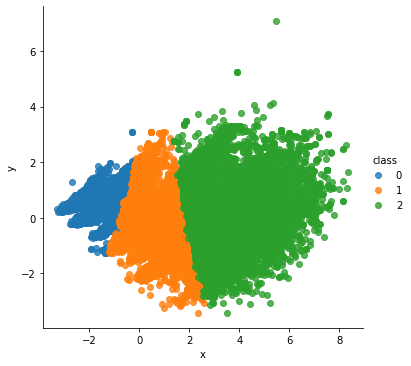

In [ ]:
data_plot = data_pca.copy()
data_plot['class'] = kmeans.labels_

sns.lmplot(x='x', y='y',
           data = data_plot,
           fit_reg = False,
           hue='class'
)

# DNN
https://towardsdatascience.com/training-neural-networks-for-price-prediction-with-tensorflow-8aafe0c55198

### Auxiliares

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
# Funciones auxiliares
def performance_summary(model, X_test, y_test ):
    
    y_hat=model.predict(X_test)
    
    df_summary=pd.DataFrame(y_hat, columns=["y_hat"])
    df_summary["y_true"]=y_test
    df_summary["abs_error"]=np.abs(df_summary.y_true-df_summary.y_hat)
    df_summary["error"]=df_summary.y_hat-df_summary.y_true
    df_summary["relative_error"]= df_summary["error"]/df_summary.y_true
    df_summary["relative_abs_error"]= df_summary["abs_error"]/df_summary.y_true
    
    share_within_5pct=(df_summary.query("relative_abs_error<0.05").shape[0]/df_summary.shape[0])*100
    
    print("{:.2f}% : Share of forecasts within 5% absolute error\n".format(share_within_5pct))
    print("{:.0f}   : Mean absolute error \n".format(df_summary.abs_error.mean()))
    print("{:.2f}% : Mean absolute percentage error\n".format(df_summary.relative_abs_error.mean()*100))

def DNN_plot_loss(history, starting_epoch, previous_val_loss):

        trace0=go.Scatter(
                y=history.history['loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="blue",
                size=5,
                opacity=0.5
                ),
                name="Training Loss"
            )


        trace1=go.Scatter(
                y=history.history['val_loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="red",
                size=5,
                opacity=0.5
                ),
                name="Validation Loss"
            )
        
        trace2=go.Scatter(
                y=list(np.ones([len(history.epoch[starting_epoch:])])*np.asarray(previous_val_loss).min()),
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="grey",
                size=5,

                ),
                name="Lowest error from previous models"
            )

        data=[trace0, trace1,trace2]
        figure=go.Figure(
            data=data,
            layout=go.Layout(
                title="Learning curve",
                yaxis=dict(title="Loss",range=(900,1500)),
                xaxis=dict(title="Epoch",range=(starting_epoch,history.epoch[-1])),
                legend=dict(
                    x=0.57,
                    y=1,
                    traceorder="normal",
                    font=dict(
                        family="sans-serif",
                        size=12,
                        color="black"
                    ),
                bgcolor=None,



            )))
        iplot(figure)

### Modelo

In [ ]:
# Libs
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from matplotlib.pyplot import figure
# from keras.utils.vis_utils import kplot_model
from tensorflow.keras.utils import plot_model


import keras

# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme

import plotly.figure_factory as ff
import plotly.graph_objects as go

# Se resetea el dataset
# La data ya se encuentra estandarizada y normalizada
data_dnn = data_norm

# Se arman los datos de entrenamiento
# x = data_dnn
# y = data_dnn.price
x_train, x_test, y_train, y_test = train_test_split(data_dnn, data_dnn.price, test_size=0.2, random_state=15)

# Strings a números

def encode(df: pd.DataFrame):
    encoder = LabelEncoder()
    return encoder.fit_transform(df)

encodables = ['neighborhood', 'property_type']

for encodable in encodables:
    data_dnn[encodable] = encode(data_dnn[encodable])
    data_dnn[encodable] = scaler.fit_transform(data_dnn[encodable].values.reshape(-1, 1))    

data_dnn.head()

# Transformar de pd.DataFrame a arrays de numpy para meteren modelo de keras
x_train = np.asanyarray(x_train).astype('float32')
x_test = np.asanyarray(x_test).astype('float32')
y_train = np.asanyarray(y_train).astype('float32')
y_test = np.asanyarray(y_test).astype('float32')

# x_train.head()

,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
235,-0.267523,-0.760747,-0.980746,-0.623106,-0.415386,-0.218493,-0.729578,-0.309025
236,-1.332352,-0.760747,-0.980746,-0.623106,1.563930,2.218777,0.329132,-0.309025
237,0.012695,-0.760747,-0.980746,-0.623106,-0.922284,-1.021008,-0.907679,-0.309025
238,0.573132,-0.760747,-0.980746,-0.623106,-0.463662,-0.961563,-0.965397,2.929732
240,0.853350,-0.760747,-0.980746,-0.623106,-0.777456,-0.753503,-0.734525,-0.309025


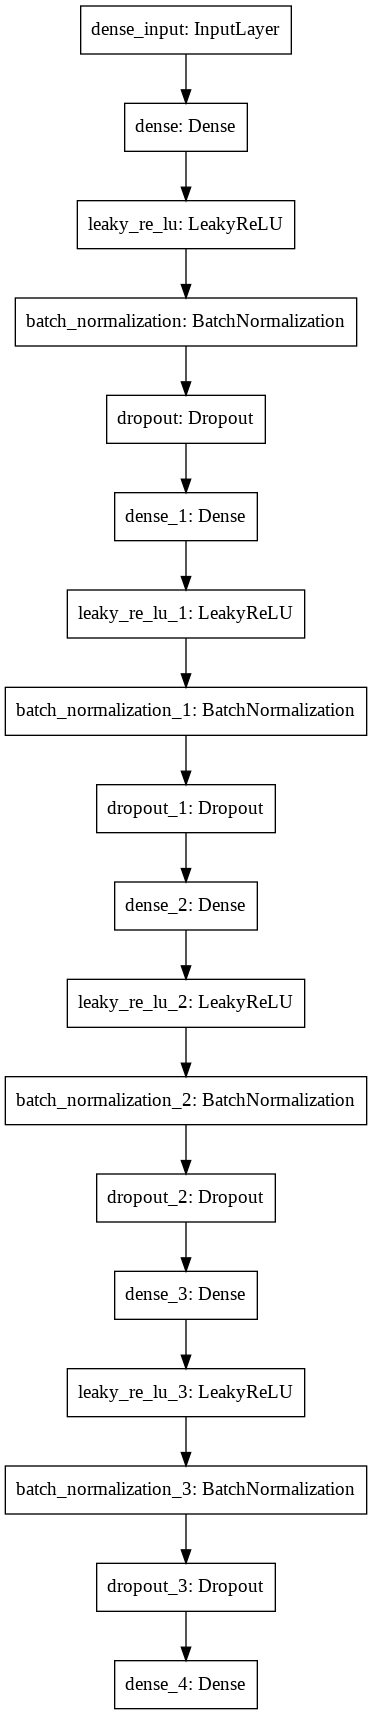

In [ ]:
# Configuración

# copypaste
tf.keras.backend.clear_session()
tf.random.set_seed(60)

# Activación RELU para capas ocultas
# "Use RELU activation function for all hidden layers — you will be going nowhere with default sigmoid activation"
# Use Linear activation function for the single-neuron output layer
k = 1
k = 16

model = Sequential([
    Dense(512, input_dim = x_train.shape[1]),
    LeakyReLU(), # Función Activación (Modificación de RELU que permite activar valores negativos -> preveiene matar neuronas)
    BatchNormalization(), # Evita que neuronas muertas tengan efecto negativo en la RN
    Dropout(0.3), # Mata neuronas para evitar sobre entrenamiento

    Dense(512),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),

    # Capa de salida
    Dense(1, activation='linear'),  # La salida es el precio (1 sólo valor)
], name="Modelo")

plot_model(model)

In [ ]:
# Optimizador ??

# Loss: pérdida entre lo que se busca y lo que el modelo encuentra

# optimizer = keras.optimizers.Adam(lr=0.005, decay=5e-4)  Cuando tengamos todo lindo
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss='mean_absolute_error')



def callbacks():
    checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]

history = model.fit(x_train, y_train,
                    epochs=300, batch_size=1024,
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks(),
                    verbose=True)

Epoch 1/300
48/48 [==============================] - 7s 109ms/step - loss: 1.0157 - val_loss: 0.5330
Epoch 2/300
48/48 [==============================] - 5s 102ms/step - loss: 0.4854 - val_loss: 0.4810
Epoch 3/300
48/48 [==============================] - 5s 106ms/step - loss: 0.3925 - val_loss: 0.4306
Epoch 4/300
48/48 [==============================] - 5s 105ms/step - loss: 0.3157 - val_loss: 0.4093
Epoch 5/300
48/48 [==============================] - 5s 103ms/step - loss: 0.2482 - val_loss: 0.3789
Epoch 6/300
48/48 [==============================] - 5s 102ms/step - loss: 0.1967 - val_loss: 0.3115
Epoch 7/300
48/48 [==============================] - 5s 101ms/step - loss: 0.1609 - val_loss: 0.2662
Epoch 8/300
48/48 [==============================] - 5s 100ms/step - loss: 0.1321 - val_loss: 0.2094
Epoch 9/300
48/48 [==============================] - 5s 100ms/step - loss: 0.1100 - val_loss: 0.1178
Epoch 10/300
48/48 [==============================] - 5s 102ms/step - loss: 0.0950 - val_lo

In [ ]:
model.summary()


Model: "Modelo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4608      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048 

<Figure size 960x480 with 0 Axes>

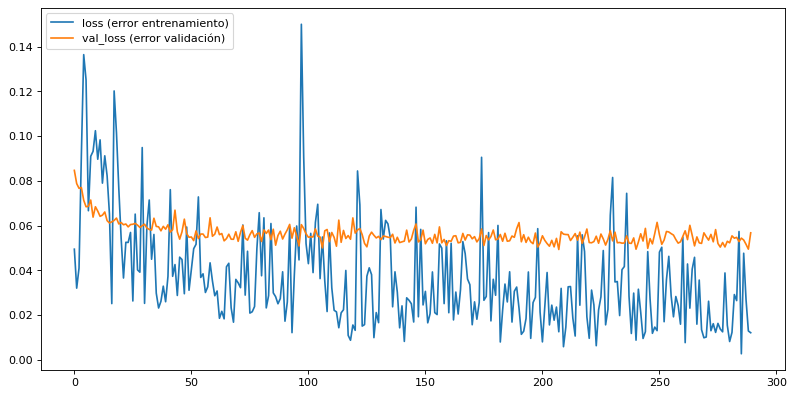

In [ ]:
figure(figsize=(12, 6), dpi=80)
                # y=history.history['loss'][starting_epoch:],
                # x=history.epoch[starting_epoch:],
# plot_data = history.history[10::]

plt.plot(history.history['val_loss'][10::])
plt.plot(history.history['loss'][10::])

plt.legend(['loss (error entrenamiento)', 'val_loss (error validación)'], loc='upper left')
plt.show()